## Lets Code IK (Inverse Kinematics) from Scratch

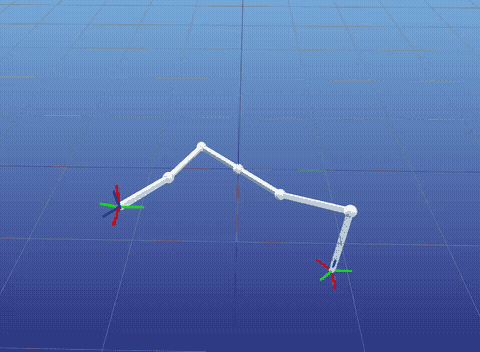

Having worked in the robotics space for a number of years, i've been quite unsatisfied with IK tutorials online, and have been wanting to write a barebones IK (Inverse Kinematics) solver for multi-body trees for anyone to understand. Basically, no complex robot representations (URDF, MJCF etc.), no rigid body library to load them and compute derivatives (Mujoco, Pinnochio), and no IK libraries or solvers. Just barebones python, numpy for the matrix math, and meshcat for the visualization. I also wanted to try to stay away from the abstraction that lie algebra offers, and try to derive most of the math ourselves even if it might be sub-optimal. The goal of this was to essentially be able to step through the math and code cell by cell, and motiviate being able to build something like what you see above (Tracking two targets with two arms with 12 DOF each). Before jumping into this, i highly recommend reading this **Optimization Basics** tutorial to get you familiar with some of the math and visuals.

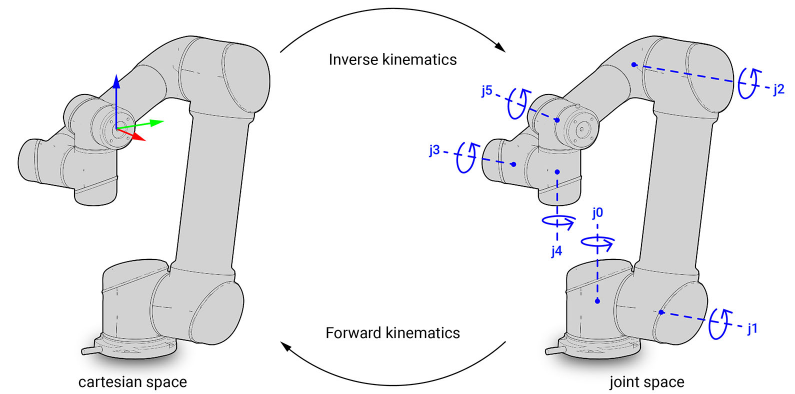

### Problem Formulation

A robot is typically defined as a series of joints <font color="blue"> {$\theta_{0}, \theta_{1}, \theta_{2}..$} </font> that generally rotate about a single axis with some range of degrees {$\theta_{min}, \theta_{max}$}, a series of links {$l_{0}, l_{1}, l_{2}..$} with fixed transforms that these joints are attached to, and a number of end-effectors used to manipulate objects {$e_{0}, e_{1}, e_{2}..$}. By driving these joint values in joint-space through a **forward kinematics** routine, we can get 6DOF pose (4x4 matrix) of each of the joints, links and most importantly the end effectors (seen in tri-color) <font color="red"> $\{T_{w}^{e_{0}},T_{w}^{e_{1}},T_{w}^{e_{2}}\}$ </font> in cartesian space in a fixed world frame or base frame: 

$FK\left(\{\theta_{0},\theta_{1},\theta_{2}..\}\right)=\{T_{w}^{e_{0}},T_{w}^{e_{1}},T_{w}^{e_{2}}\}$

Similarly, for reasons that will be explained later, an **inverse kinematics** routine can also provide the gradients or namely jacobians of how changing the values in joint space, changes each of the values of the end effector 6DOF pose: 

$IK\left(\{\theta_{0},\theta_{1},\theta_{2}..\}\right)=\left\{ \begin{array}{ccc}
\frac{d\theta_{0}}{dT_{w}^{e_{0}}} & \frac{d\theta_{1}}{dT_{w}^{e_{0}}} & \frac{d\theta_{2}}{dT_{w}^{e_{0}}}\\
\frac{d\theta_{0}}{dT_{w}^{e_{1}}} & \frac{d\theta_{2}}{dT_{w}^{e_{1}}} & \frac{d\theta_{2}}{dT_{w}^{e_{1}}}\\
\frac{d\theta_{0}}{dT_{w}^{e_{2}}} & \frac{d\theta_{1}}{dT_{w}^{e_{2}}} & \frac{d\theta_{2}}{dT_{w}^{e_{2}}}
\end{array}\right\} $

As an example, if you passed in a $\theta_{1}$ but observed that $\frac{d\theta_{1}}{dT_{w}^{e_{0}}}$ had a jacobian close to 0, it could indicate that $\theta_{1}$ may not be connected to the $e_{1}$ in the multi-body tree of the robot. So let us get started by working on a toy problem:

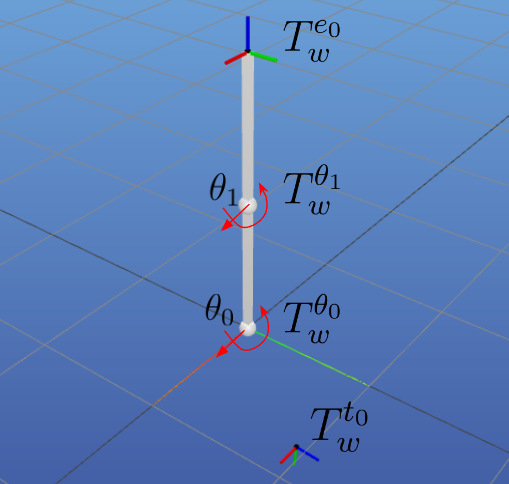

The goal is to write a generic program that can define a two link / two joint double pendulum robot model. It is parameterized by the joint space $\{\theta_{0},\theta_{1}\}$ [2 x 1], has a output in the cartesian space as a single end-effector output pose of $T_{w}^{e}$ [4 x 4], and the goal is to determine the value of the joint space, or perhaps a trajectory such that $T_{w}^{e}$ is aligned with $T_{w}^{t}$

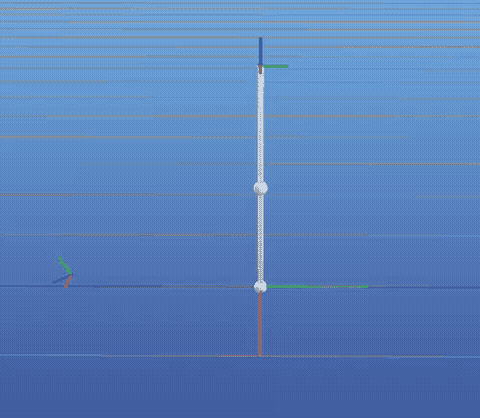

In [1]:
# Import sympy and numpy
import sympy as sp
from sympy import init_printing
sp.init_printing(use_unicode=True)
import numpy as np
import matplotlib.pyplot as plt
import math

# Import meshcat
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf
import meshcat_shapes

Now we will define our own custom robot, namely a double pendulum robot, that is supposed to look like this when the two joints defined look are at a 0 angle:

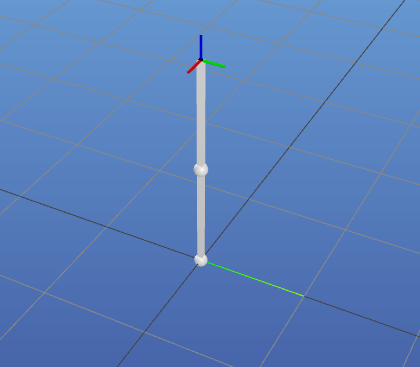

In [2]:
def translation_matrix(direction : np.array):
    """
    Given a 1x3 direction vector
    Returns a 4x4 SO3 matrix with just translation components
    """
    T = np.identity(4)
    T[:3, 3] = direction[:3]
    return T


double_pendulum_robot = {
    "base": {
        "type": "base",
        "dim": [0.025, 0.025, 0.025],
        "offset_T": translation_matrix([0, 0, 0]),
        "children": ["j0"]
    },
    "j0": {
        "type": "joint",
        "dim": 0.03,
        "axis": [1, 0, 0],
        "offset_T": translation_matrix([0, 0, 0]),
        "children": ["l0"]
    },
    "l0": {
        "type": "link",
        "dim": [0.025, 0.025, 0.5],
        "offset_T": translation_matrix([0, 0, 0.25]),
        "children": ["j1"],
    },
    "j1": {
        "type": "joint",
        "dim": 0.03,
        "axis": [1, 0, 0],
        "offset_T": translation_matrix([0, 0, 0.25]),
        "children": ["l1"],
    },
    "l1": {
        "type": "link",
        "dim": [0.025, 0.025, 0.5],
        "offset_T": translation_matrix([0, 0, 0.25]),
        "children": ["ef"],
    },
    "ef": {
        "type": "ef",
        "dim": 0.03,
        "offset_T": translation_matrix([0, 0, 0.25]),
        "children": [],
    }
}
for key, frame in double_pendulum_robot.items():
    frame["key"] = key

### Helper methods

Notice how this robot defines a dictionary of frame names, where each frame is either a `base`, `joint`, `link` or an `ef` (end-effector). For each of these, we provide a `dim` variable that acts as a visual field, an `offset_T` that indicates its 6DOF offset relative to its parent, a `children` array that indicates how the tree flows, and an `axis` that indicates along what axis is the joint rotating, in this case being the `X` axis of `[1, 0, 0]`. By looking at how the `children` tag looks like, we can see it flows as such `base -> j0 -> l0 -> j1 -> l1 -> ef`

The next step involves writing a nice helper method in python, that lets us iterate over this frame tree, in a DFS manner but starting at the root node and going down, while also returning the parent key, and the trajectory of the nodes as well. This sort of iteration is critical as computing the pose of one link will rely on it's parent pose. This applies to the gradients as well

In [3]:
def iterate_frames(frames, starting="base"):
    """
    A helper method to iterate a robot frame tree in a BFS manner so we always visit the parent before child
    """
    stack = [(frames[starting], [starting])]
    while stack:
        curr_node, curr_traj = stack.pop()
        parent_key = None
        if len(curr_traj) >= 2: parent_key = curr_traj[-2]
        parent_node = None
        if parent_key in frames.keys(): parent_node = frames[parent_key]
        yield curr_node, parent_node, curr_traj
        for child in curr_node["children"]:
            if child in frames:
                stack.append((frames[child], curr_traj + [child]))

# Print the frame, parent and trajectory
frames = double_pendulum_robot
for curr_frame, parent_frame, frame_traj in iterate_frames(frames):
    if parent_frame is not None:
        print("frame:", curr_frame["key"], "parent:", parent_frame["key"], "traj:", frame_traj)
    else:
        print("frame:", curr_frame["key"], "traj:", frame_traj)

# Setup a cache to store the trajectory
traj_cache = {}
for curr_node, parent_node, curr_traj in iterate_frames(frames):
    curr_key = curr_node["key"]
    traj_cache[curr_key] = curr_traj

frame: base traj: ['base']
frame: j0 parent: base traj: ['base', 'j0']
frame: l0 parent: j0 traj: ['base', 'j0', 'l0']
frame: j1 parent: l0 traj: ['base', 'j0', 'l0', 'j1']
frame: l1 parent: j1 traj: ['base', 'j0', 'l0', 'j1', 'l1']
frame: ef parent: l1 traj: ['base', 'j0', 'l0', 'j1', 'l1', 'ef']


Now let us setup the visualizer and draw the raw joints and links to it

In [4]:
vis = meshcat.Visualizer()
# vis.jupyter_cell() # If you want to see it here

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [6]:
for name, frame in frames.items():
    if frame["type"] == "base":
        vis[name].set_object(g.Box(frame["dim"]))
    elif frame["type"] == "link":
        vis[name].set_object(g.Box(frame["dim"]))
    elif frame["type"] == "joint":
        vis[name].set_object(g.Sphere(frame["dim"]))
    elif frame["type"] == "ef":
        vis[name].set_object(g.Sphere(frame["dim"]))

We then write a helper method to get a sample joint space input `{'j0': 0, 'j1': 0}`

In [7]:
def get_joint_space_input(frames):
    inputs = {}
    for curr_node, parent_node, _ in iterate_frames(frames):
        if curr_node["type"] == "joint":
            inputs[curr_node["key"]] = 0
    return inputs

inputs = get_joint_space_input(frames)
print(inputs)

{'j0': 0, 'j1': 0}


Great! This is the very first step in setting up most of the raw elements we need to do **forward kinematics** first. But we are missing one crucial component. Similar to how we have a `translation_matrix` method that takes in a 3d position to generate a valid 6DOF pose, we want to do the same thing for a `rotation_matrix`. Remember that the robot is being strictly parameterized by joint angles $\{\theta_{0},\theta_{1}\}$, their axis $v$ eg. `[1, 0, 0]`, to produce valid 6DOF poses of $\{T_{j_{0}}^{\theta_{0}},T_{j_{1}}^{\theta_{1}}\}$. This means we also need to understand how changing $\theta$ affects the pose $T$, meaning we also need to compute the jacobian $\frac{d\theta}{dT}$. Hence we need a method that does the following:

$\left(T,\frac{d\theta}{dT}\right)=rot\left(\theta,\left[v_{x},v_{y},v_{z}\right]\right)$

with the two outputs of the above method being a 4x4 6DOF pose, and a 4x4 jacobian. This can be acheived by the Rodrigues' rotation formula (https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula). We symbolically define them below

In [8]:
# Rodigrues rotation formula that accepts a theta
def rot(theta, v):
    def skew(v):
        return sp.Matrix([
            [0.0, -v[2],  v[1]],
            [v[2], 0.0, -v[0]],
            [-v[1], v[0], 0.0]
        ])

    sina = sp.sin(theta)
    cosa = sp.cos(theta)
    
    v @ v.T
    R = sp.eye(3)*cosa + (v @ v.T)*(1-cosa) + sina*skew(v)
    return R

# Define theta and v
theta = sp.symbols('theta')
v = sp.Matrix([1,0,0]) 
R = rot(theta, v)
R, R.diff(theta)

⎛⎡1    0        0   ⎤  ⎡0     0        0   ⎤⎞
⎜⎢                  ⎥  ⎢                   ⎥⎟
⎜⎢0  cos(θ)  -sin(θ)⎥, ⎢0  -sin(θ)  -cos(θ)⎥⎟
⎜⎢                  ⎥  ⎢                   ⎥⎟
⎝⎣0  sin(θ)  cos(θ) ⎦  ⎣0  cos(θ)   -sin(θ)⎦⎠

This can also be computed in matrix form

In [9]:
v = sp.MatrixSymbol('v', 3, 1)
v_s = sp.MatrixSymbol('v_s', 3, 3)
I = sp.MatrixSymbol('I', 3, 3)
theta = sp.symbols('theta')
sina = sp.sin(theta)
cosa = sp.cos(theta)

R = I*cosa + (v @ v.T)*(1-cosa) + sina*v_s
R, R.diff(theta)

With these equations, we can now write out python helper method, that also includes a 0 translation component. Namely we are writing a method that looks like this:

$\quad\quad T_{\theta}=r(\theta,v)$ [4 x 4] matrix where $v$ is `[1, 0, 0]`

$\quad\quad \frac{dr(\theta)}{dT_{\theta}}$ [1 x 16] to map theta to the 16 T values or [4 x 4] matrix

In [10]:
def skew(v):
    """
    Given a 1x3 direction vector
    Returns a 3x3 skew symmetric matrix 
    """
    return np.array([
        [0.0, -v[2],  v[1]],
        [v[2], 0.0, -v[0]],
        [-v[1], v[0], 0.0]
    ])

def rotation_matrix(theta : float, v : np.array, grad = False):
    """
    Given the axis angle representation of theta and v
    Returns a 4x4 SO3 matrix with just rotation components
    Returns a 4x4 dThetadT matrix as well if requested 
    """
    v = np.array(v).astype(np.float64)
    if np.linalg.norm(v) != 1:
        raise Exception("Unnormalized direction")
    sint = math.sin(theta)
    cost = math.cos(theta)
    R = (1 - cost)* (np.outer(v, v)) + sint*skew(v) + cost*np.eye(3)
    T = np.identity(4)
    T[:3, :3] = R

    if not grad: 
        return T
    else:
        dThetadR = (-sint)*np.eye(3) + sint*np.outer(v, v) + cost*skew(v)
        dThetadT = np.identity(4) * 0
        dThetadT[:3, :3] = dThetadR
        return T, dThetadT


We can verify that our gradients above are correct using the finite difference method (https://en.wikipedia.org/wiki/Numerical_differentiation)

In [11]:
# Verify rotation matrix gradient
h = 1e-5
dThetadT_numerical = (rotation_matrix(0.5 + h, [1, 0, 0]) - rotation_matrix(0.5, [1, 0, 0])) / h
dThetadT_analytical = rotation_matrix(0.5, [1, 0, 0], grad = True)[1]
assert(np.linalg.norm(dThetadT_numerical - dThetadT_analytical) < 1e-5)

### Forward Kinematics

Now we can get to the part where we can write code to drive the joint space `{'j0': 0, 'j1': 0}` and see how the end-effector of the robot above moves. For our robot, the transformations to map the joint space ${\theta_{0}, \theta_{1}}$ to $T_{w}^{e}$ can be composed as follows, the function $r$ representing the `rotation_matrix` method above:

$\quad\quad T_{w}^{j_{0}}=r(\theta_{0}).T_{b}^{j_{0}}.T_{w}^{b}$

$\quad\quad T_{w}^{l_{0}}=T_{j_{0}}^{l_{0}}.T_{w}^{j_{0}}$

$\quad\quad T_{w}^{j_{1}}=r(\theta_{1}).T_{l_{0}}^{j_{1}}.T_{w}^{l_{0}}$

$\quad\quad T_{w}^{l_{1}}=T_{j_{1}}^{l_{1}}.T_{w}^{j_{1}}$

$\quad\quad T_{w}^{e}=T_{l_{1}}^{e}.T_{w}^{l_{1}}$

In [12]:
import copy
base_transform = frames["base"]["offset_T"]
j0_T, j0_t0_grad = rotation_matrix(inputs["j0"], frames["j0"]["axis"], grad=True)
frames["j0"]["global_T"] = base_transform @ frames["j0"]["offset_T"] @ j0_T
frames["l0"]["global_T"] = frames["j0"]["global_T"]  @ frames["l0"]["offset_T"]
j1_T, j1_t1_grad = rotation_matrix(inputs["j1"], frames["j1"]["axis"], grad=True)
frames["j1"]["global_T"] = frames["l0"]["global_T"] @ frames["j1"]["offset_T"] @ j1_T
frames["l1"]["global_T"] = frames["j1"]["global_T"] @ frames["l1"]["offset_T"]
frames["ef"]["global_T"] = frames["l1"]["global_T"] @ frames["ef"]["offset_T"]
ef_frame = frames["ef"]["global_T"]
print(inputs)
print(ef_frame)

{'j0': 0, 'j1': 0}
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]]


We could represent the transforms this way, or write a more general method as follows:

In [13]:
def fk(frames, inputs, viz = False, vis = None):

    # Iterate FK chain
    for curr_node, parent_node, _ in iterate_frames(frames):
        curr_key = curr_node["key"]

        # Base frame
        if curr_node["type"] == "base":
            curr_node["global_T"] = curr_node["offset_T"]

        # Joint frame
        elif curr_node["type"] == "joint":
            curr_node["j_T"], curr_node["j_T_grad"] = rotation_matrix(inputs[curr_key], curr_node["axis"], grad=True)
            curr_node["global_T"] = parent_node["global_T"] @ curr_node["offset_T"] @ curr_node["j_T"]

        # Link frame
        elif curr_node["type"] == "link" or curr_node["type"] == "ef":
            curr_node["global_T"] = parent_node["global_T"] @ curr_node["offset_T"]

    # Visualize
    if viz:
        for curr_node, parent_node, _ in iterate_frames(frames):
            curr_key = curr_node["key"]
            vis[curr_key].set_transform(curr_node["global_T"])
            if curr_node["type"] == "ef":
                meshcat_shapes.frame(vis[curr_key])

fk(frames, inputs)
print(inputs)
print(frames["ef"]["global_T"])

{'j0': 0, 'j1': 0}
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]]


Lets try to cycle through the joints and visualize it

In [15]:
import time
for j_val in np.arange(-np.pi/2, np.pi/2, 0.01):
    input_sample = get_joint_space_input(frames)
    input_sample["j0"] = j_val
    input_sample["j1"] = j_val
    fk(frames, input_sample, True, vis=vis)
    time.sleep(0.01)

You should see something like this on the gamepad

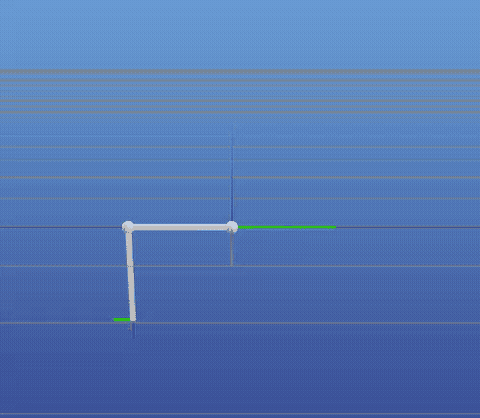

### Inverse Kinematics

Now we can get to the part where we understand how the joint space varies with the end effector pose. Specifically, we compute the jacobians as such. 

We first compute $\theta_{0}$ relative to all the other frames:

$\quad\quad \frac{d\theta_{0}}{dT_{j0}}=\frac{dr(\theta_{0})}{dT_{j_{0}}}.T_{b}^{j_{0}}.T_{w}^{b}$

$\quad\quad \frac{d\theta_{0}}{dT_{l_{0}}}=T_{j_{0}}^{l_{0}}.\frac{d\theta_{0}}{dT_{j0}}$

$\quad\quad \frac{d\theta_{0}}{dT_{j_{1}}}=r(\theta_{1}).T_{l_{o}}^{j_{1}}.\frac{d\theta_{0}}{dT_{l_{0}}}$

$\quad\quad \frac{d\theta_{0}}{dT_{l_{1}}}=T_{j_{1}}^{l_{1}}.\frac{d\theta_{0}}{dT_{j_{1}}}$

$\quad\quad \frac{d\theta_{0}}{dT_{e}}=T_{l_{1}}^{e}.\frac{d\theta_{0}}{dT_{l_{1}}}$


We then compute $\theta_{1}$ relative to all the other frames:

$\quad\quad \frac{d\theta_{1}}{dT_{j0}}=r(\theta_{0}).T_{b}^{j_{0}}.T_{w}^{b}$

$\quad\quad \frac{d\theta_{1}}{dT_{l_{0}}}=T_{j_{0}}^{l_{0}}.\frac{d\theta_{0}}{dT_{j0}}$

$\quad\quad \frac{d\theta_{1}}{dT_{j_{1}}}=\frac{dr(\theta_{1})}{dT_{j_{1}}}.T_{l_{o}}^{j_{1}}.\frac{d\theta_{0}}{dT_{l_{0}}}$

$\quad\quad \frac{d\theta_{1}}{d_{l_{1}}}=T_{j_{1}}^{l_{1}}.\frac{d\theta_{0}}{d_{j_{1}}}$

$\quad\quad \frac{d\theta_{1}}{dT_{e}}=T_{l_{1}}^{e}.\frac{d\theta_{0}}{dT_{l_{1}}}$

What we eventually want is a matrix in the form of
$\frac{d\theta}{d_{T_{e}}}=\left[\begin{array}{c}
\frac{d\theta_{0}}{dT_{e}}\\
\frac{d\theta_{1}}{dT_{e}}
\end{array}\right]$ that we can use to map a changing $\{\dot{\theta_{0}},\dot{\theta_{1}}\}$ value to

In [16]:
# t0
j0_t0_grad = base_transform @ frames["j0"]["offset_T"] @ j0_t0_grad
l1_t0_grad = j0_t0_grad  @ frames["l0"]["offset_T"]
j1_t0_grad = l1_t0_grad @ frames["j1"]["offset_T"] @ j1_T
l2_t0_grad = j1_t0_grad @ frames["l1"]["offset_T"]
ef_t0_grad = l2_t0_grad @ frames["ef"]["offset_T"] 

# t1
j0_t1_grad = base_transform @ frames["j0"]["offset_T"] @ j0_T
l1_t1_grad = j0_t1_grad  @ frames["l0"]["offset_T"]
j1_t1_grad = l1_t1_grad @ frames["j1"]["offset_T"] @ j1_t1_grad
l2_t1_grad = j1_t1_grad @ frames["l1"]["offset_T"]
ef_t1_grad = l2_t1_grad @ frames["ef"]["offset_T"]

print(inputs)
print(ef_t0_grad)
print(ef_t1_grad)

{'j0': 0, 'j1': 0}
[[ 0.  0.  0.  0.]
 [ 0.  0. -1. -1.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]]
[[ 0.   0.   0.   0. ]
 [ 0.   0.  -1.  -0.5]
 [ 0.   1.   0.   0. ]
 [ 0.   0.   0.   0. ]]


We could represent the transforms this way, or write a more general method as follows:

In [17]:
def ik(frames, inputs):
    # Iterate IK chain
    for j in inputs.keys():

        # Iterate FK chain
        for curr_node, parent_node, _ in iterate_frames(frames):
            curr_key = curr_node["key"]

            # Base frame
            if curr_node["type"] == "base":
                curr_node["global_J_" + j] = curr_node["global_T"]

            # Joint frame
            elif curr_node["type"] == "joint":
                if curr_key == j:
                    j_grad = curr_node["j_T_grad"]
                else:
                    j_grad = curr_node["j_T"]
                curr_node["global_J_" + j] = parent_node["global_J_" + j] @ curr_node["offset_T"] @ j_grad

            # Link frame
            elif curr_node["type"] == "link" or curr_node["type"] == "ef":
                curr_node["global_J_" + j] = parent_node["global_J_" + j]  @ curr_node["offset_T"]

fk(frames, inputs)
ik(frames, inputs)
print(frames["ef"]["global_J_j0"])
print(frames["ef"]["global_J_j1"])

[[ 0.  0.  0.  0.]
 [ 0.  0. -1. -1.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  0.]]
[[ 0.   0.   0.   0. ]
 [ 0.   0.  -1.  -0.5]
 [ 0.   1.   0.   0. ]
 [ 0.   0.   0.   0. ]]


### Loss Function

Now that we have a forward kinematics method that can map $\{\theta_{0},\theta_{1}\}$ to a $T_{w}^{e}$ and an inverse kinematics method that can create a end effector $\frac{d\theta}{d_{T_{e}}}$ jacobian, we have most of the pieces now to be able to solve the problem of solving for a novel $\{\theta_{0}^{t},\theta_{1}^{t}\}$ value given target $T_{w}^{t}$

We setup a simple least squares where our goal is to ensure that $T_{w}^{e}$ and $T_{w}^{t}$ are close so:

$\quad\quad l=\left(\left(T_{w}^{e}-T_{w}^{t}\right)∘w\right)^{2}$ [Flattened to a 1 x 16 vector]

where $w$ is a weight matrix so we can control how much weight is given to the rotation and translation components.

From that we can also define the gradient:

$\quad\quad J=\frac{dl}{d\theta}=2∘\left(\left(T_{w}^{e}-T_{w}^{t}\right)∘w\right)∘\left(\frac{d\theta}{d_{T_{e}}}\right)$ [Flattened to a 16 x 2 vector]

Lets write some code for this

In [18]:
def weight_matrix(ow : float, tw : float):
    """
    Given an orientation weight and translation weight
    Returns a 4x4 weight matrix to be applied to a 4x4 SO3 matrix
    """
    w = np.zeros((4,4))
    w[0:3, 0:3] = ow
    w[0:3, 3] = tw
    return w

def target_loss(inputs, targets):
    # Define ef target losses and grads
    ef_losses = []
    ef_grads = []

    # Iterate over targets
    for target_key, target in targets.items():
        
        # Compute target loss
        loss = (frames[target_key]["global_T"] - target["T"]) * target["w"]
        squared_loss = loss**2
        ef_losses.append(squared_loss.flatten())

        # Iterate each input variable
        grads = []
        for input_key, _ in inputs.items():
            loss_J = 2 * (loss.flatten()) * frames[target_key]["global_J_" + input_key].flatten()
            grads.append(loss_J)

        grads = np.vstack(grads)
        ef_grads.append(grads.T)

    # Sum and combine the ef losses and joint losses
    ef_losses = np.sum(np.array(ef_losses), axis=0)
    
    # Sum and combine the ef grads and joint grads
    ef_grads = np.sum(np.array(ef_grads), axis=0)
    
    return ef_losses, ef_grads

fk(frames, inputs)
ik(frames, inputs)
loss, grad = target_loss(inputs, {"ef" : {"T": frames["ef"]["global_T"], "w" : weight_matrix(1, 1)}})
print(loss)
print(grad)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


Lets write some code to setup the problem below. We start out with our robot in its nominal pose of 0 angle for both joints, and we want to hit the desired target below that is within the robot workspace:

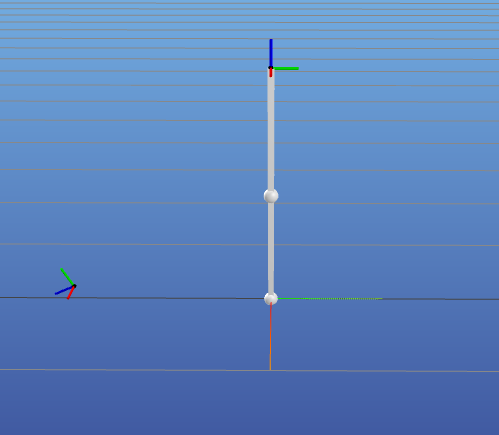

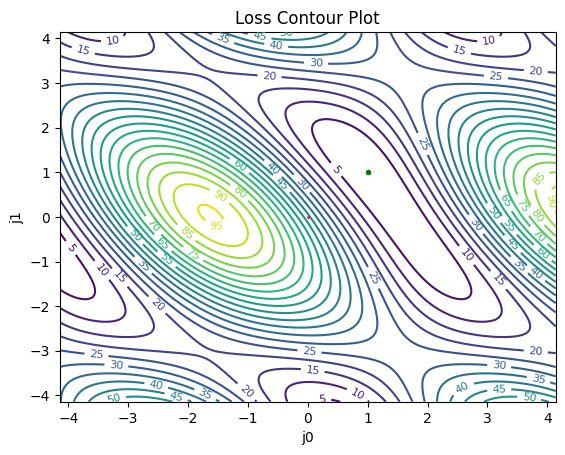

In [84]:
init_input = {"j0": 0, "j1": 0}
target_input = {"j0": 1, "j1": 1}
fk(frames, target_input, True, vis)
target_output = {"ef" : {"T": frames["ef"]["global_T"], "w" : weight_matrix(1, 5)}}
vis["target"].set_transform(frames["ef"]["global_T"])
meshcat_shapes.frame(vis["target"])
fk(frames, init_input, True, vis)

# Generate sample data for the loss landscape
x = np.linspace(-np.pi - 1.0, np.pi + 1.0, 150)
y = np.linspace(-np.pi - 1.0, np.pi + 1.0, 150)
X, Y = np.meshgrid(x, y)
Z = (X**2 + Y**2)
for u in range(0, x.shape[0]):
    for v in range(0, y.shape[0]):
        j0 = X[u,v]
        j1 = Y[u,v]
        fk(frames, {"j0": j0, "j1": j1})
        loss, grad = target_loss({"j0": j0, "j1": j1}, target_output)
        Z[u,v] = np.sum(loss)

def draw_contour_plot(X, Y, Z, init_input, target_input):
    fig, ax = plt.subplots()
    contour = ax.contour(X, Y, Z, levels=20, cmap='viridis')
    plt.clabel(contour, inline=True, fontsize=8)
    plt.title('Loss Contour Plot')
    plt.xlabel('j0')
    plt.ylabel('j1')
    viz_targets = [[target_input["j0"], target_input["j1"]], [target_input["j0"]-np.pi*2, target_input["j1"]], [target_input["j0"], target_input["j1"]-np.pi*2]]
    for vt in viz_targets:
        ax.plot(vt[0], vt[1], marker="o", markersize=3, markeredgecolor="green", markerfacecolor="green")
        break
    ax.plot(init_input["j0"], init_input["j1"], marker="o", markersize=1, markeredgecolor="red", markerfacecolor="red")
    return ax

# Draw contour plot
ax = draw_contour_plot(X, Y, Z, init_input, target_input)

From this starting position, we want to solve for the joint space values that guide as towards the end effector target

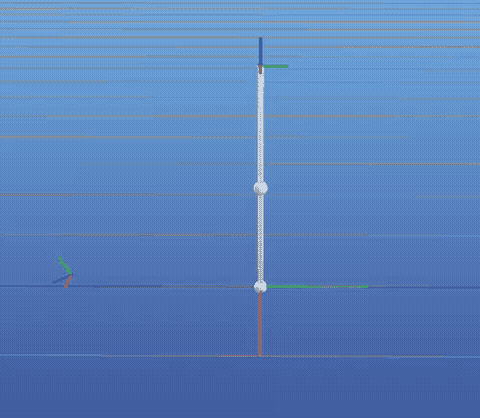

{'j0': 1, 'j1': 1}
{'j0': 1.00149764981728, 'j1': 0.9949623348971487}


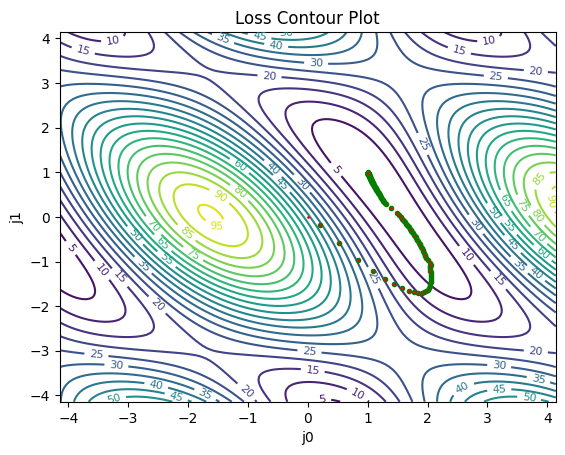

In [86]:
init_input = {"j0": 0, "j1": 0}

# Draw contour plot
ax = draw_contour_plot(X, Y, Z, init_input, target_input)

def get_loss_and_grad(frames, init_input, target_output, vis):
    fk(frames, init_input, True, vis)
    ik(frames, init_input)
    loss, grad = target_loss(init_input, target_output)
    return loss, grad

def solve(frames, init_input, target_output, loss_and_grad_fn, ax, sleep=0.01):
    # Solve
    prev_loss = 100
    total_iter = 0
    lr = 0.05
    min_eps = 1e-5
    max_iter = 1000
    while 1:
        # Compute IK
        loss, grad = loss_and_grad_fn(frames, init_input, target_output, vis)

        # Compute optimal step with gauss newton
        step = (np.linalg.inv(grad.T @ grad) @ grad.T @ loss) * lr
    
        # Pass step into state vector
        init_input["j0"] = init_input["j0"] - step[0]
        init_input["j1"] = init_input["j1"] - step[1]
    
        # Plot
        ax.plot(init_input["j0"], init_input["j1"], marker="o", markersize=3, markeredgecolor="green", markerfacecolor="red")
    
        # Termination
        total_iter += 1
        loss = np.sum(loss)
        eps = np.abs(loss - prev_loss) 
        prev_loss = loss
    
        # No more updates possible
        if eps < min_eps: break
    
        # Too many iterations
        if total_iter > max_iter: break
        
        # Sleep if viz on
        time.sleep(sleep)

    return init_input

solve(frames, init_input, target_output, get_loss_and_grad, ax)
print(target_input)
print(init_input)

Thats great! We were able to solve for the trajectory to get to the target we need. We can even see how the trajectory is traced on the loss manifold. 

### Joint Limits

Now let us try some slightly different parameters where we start from this position but want to head to the one indicated below

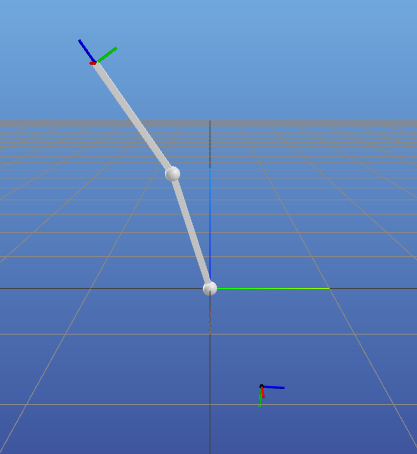

{'j0': -0.9913800597646566, 'j1': 4.299687305754584}

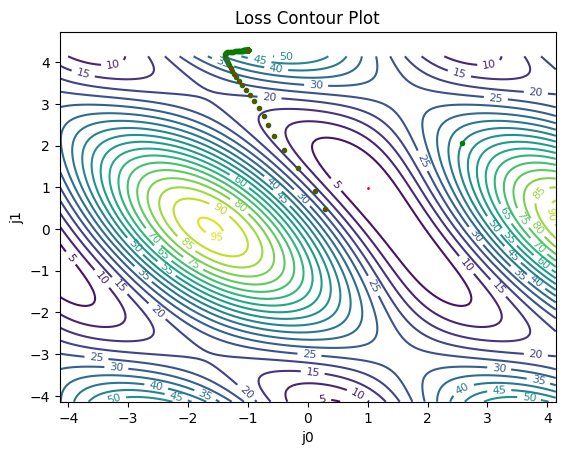

In [87]:
target_input = {"j0": np.pi/2 + 1.0, "j1": np.pi/2 + 0.5}
fk(frames, target_input, True, vis)
target_output = {"ef" : {"T": frames["ef"]["global_T"], "w" : weight_matrix(1, 5)}}
vis["target"].set_transform(frames["ef"]["global_T"])
meshcat_shapes.frame(vis["target"])
fk(frames, init_input, True, vis)

# Draw contour plot
ax = draw_contour_plot(X, Y, Z, init_input, target_input)

# Solve
init_input = {"j0": 0.3, "j1": 0.3}
solve(frames, init_input, target_output, get_loss_and_grad, ax, sleep=0.1)

This time you can see that the results are a bit unsatisfying. You can see that the the actuator j1 has exceeded the bounds of the plot itself into a local optimum, not hitting the desired target. You can also see that it basically passed through itself.

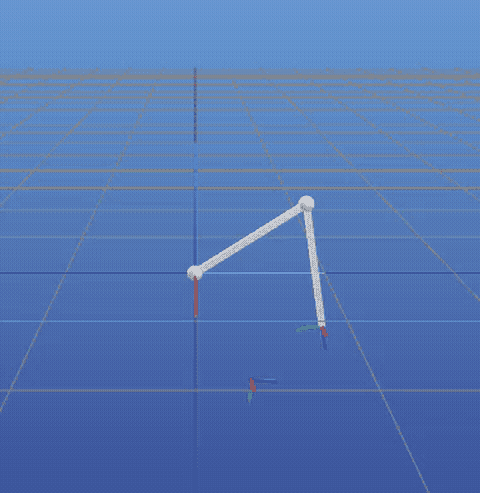

Would it not be great if we can have a forcing function to prevent ensure that our joint space variables stay within some bounds?

Ideally, we would want to design a function that might look like this:

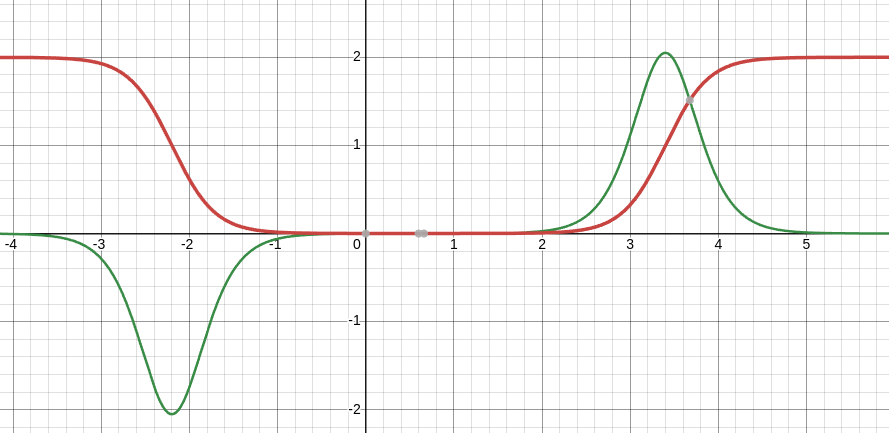

Where as long as say $\theta_1$ lies between [-2, 3] we would have a loss of 0, and as it approaches those values, it starts to shoot up towards some higher value. We can also see how the gradient in green responds during those regions. You can imagine that boundary effectively getting mapped onto the loss manifold above, preventing the overshoot into the local minima.

You can design this function by starting out with $\frac{1}{1+\exp\left(1x\right)}$

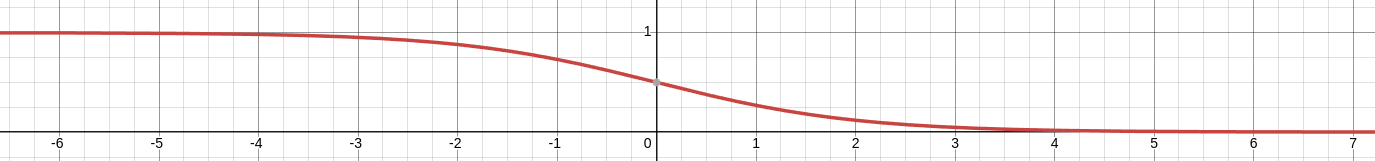

and with a little tweaking you get eventually get the method:

$\quad\quad l = m\cdot\left(1-\left(\frac{1}{1+\exp\left(-s\left(x-\left(l\right)\right)\right)}\cdot\frac{1}{1+\exp\left(-s\left(-x+r\right)\right)}\right)\right)$

where $m$ represents the max height the loss can reach, $[ll, lr]$ represent the actuator range, $s$ represents a skew factor and $x$ here represents the actuator angle / input itself. You can play around with it on desmos at this link: https://www.desmos.com/calculator/aja9qlbmc8

The gradient is a little gnarly to compute, so lets derive it symbolically

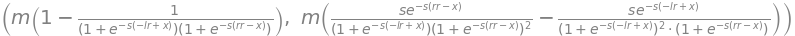

In [88]:
x, s, m, lr, rr = sp.symbols('x s m lr rr')
f = m*(1-((1/(1+sp.exp(-s*(x-lr)))) * (1/(1+sp.exp(-s*(-x+rr))))))
f, f.diff(x)

Time to code this up and verify the gradient with numerical gradients!

In [89]:
# A method that returns 0 within range or the max val otherwise
def joint_limit(x, range, max, skew=10., grad=False):
    """
    A method that returns 0 if x is within range or tends to max otherwise
    """
    # https://www.desmos.com/calculator/udhsuxoayj
    lr = range[0]
    rr = range[1]
    s = skew
    m = max

    a = np.exp(-s*(x-lr)) # a
    b = np.exp(-s*(-x+rr)) # b
    limit = m * (1 - (1/(1+a)) * (1/(1+b)))
    if not grad:
        return limit
    dLimitdX = m * ((s*b)/((b+1)**2 * (a+1)) - (s*a)/((a+1)**2 * (b+1)))
    return limit, dLimitdX

# Verify joint limit gradient
h = 1e-5
dLimitdX_numerical = (joint_limit(-2 + h, range=[-2,2], max=2.) - joint_limit(-2, range=[-2,2], max=2.)) / h
limit, dLimitdX_analytical = joint_limit(-2 + h, range=[-2,2], max=2., grad=True)
assert(np.linalg.norm(dLimitdX_numerical - dLimitdX_analytical) < 1e-5)


Lets now visualize the loss manifold with the joint loss added

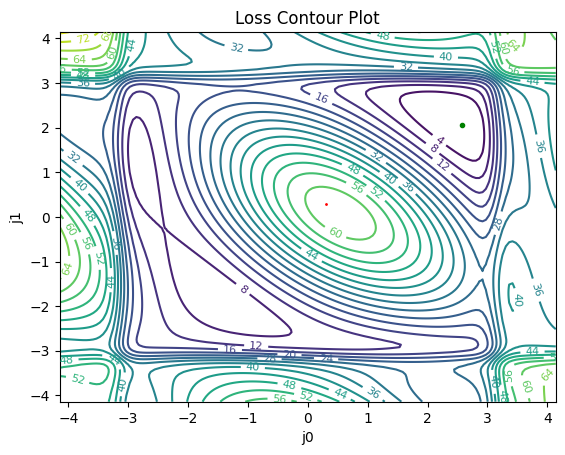

In [92]:
def joint_loss(init_input):
    joint_limit_loss = []
    joint_limit_grad = []
    for joint_name, joint_value in init_input.items():
        jloss, jgrad = joint_limit(joint_value, [-np.pi, np.pi], max=25, skew=10, grad=True)
        joint_limit_loss.append(jloss)
        joint_limit_grad.append(jgrad)
    joint_limit_loss = np.array(joint_limit_loss)
    joint_limit_grad = np.array(joint_limit_grad) * np.eye(len(joint_limit_grad))

    return joint_limit_loss, joint_limit_grad

# Generate sample data for the loss landscape
x = np.linspace(-np.pi - 1.0, np.pi + 1.0, 150)
y = np.linspace(-np.pi - 1.0, np.pi + 1.0, 150)
X, Y = np.meshgrid(x, y)
Z = (X**2 + Y**2)
for u in range(0, x.shape[0]):
    for v in range(0, y.shape[0]):
        j0 = X[u,v]
        j1 = Y[u,v]
        fk_input = {"j0": j0, "j1": j1}
        fk(frames, fk_input)
        loss, grad = target_loss(fk_input, target_output)
        jloss, jgrad = joint_loss(fk_input)    
        Z[u,v] = np.sum(loss) + np.sum(jloss)

# Draw contour plot
init_input = {"j0": 0.3, "j1": 0.3}
ax = draw_contour_plot(X, Y, Z, init_input, target_input)

Success! Now we can see a clearly defined boundary that might prevent the  

{'j0': 2.466360689234819, 'j1': 2.153712059173031}

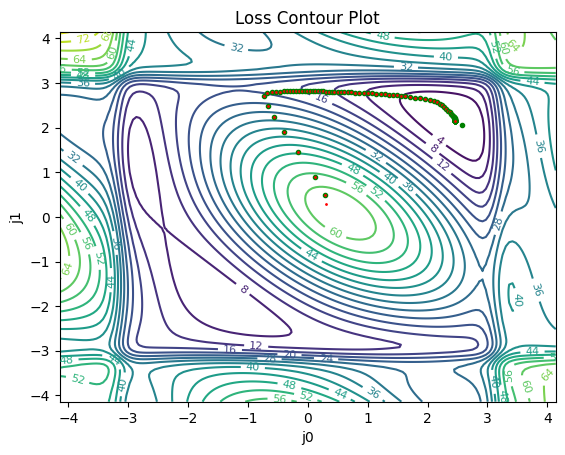

In [95]:
def get_loss_and_grad_2(frames, init_input, target_output, vis):
    fk(frames, init_input, True, vis)
    ik(frames, init_input)
    loss, grad = target_loss(init_input, target_output)
    jloss, jgrad = joint_loss(init_input)
    loss = np.hstack([loss, jloss])
    grad = np.vstack([grad, jgrad])

    return loss, grad

# Generate sample data for the loss landscape
x = np.linspace(-np.pi - 1.0, np.pi + 1.0, 150)
y = np.linspace(-np.pi - 1.0, np.pi + 1.0, 150)
X, Y = np.meshgrid(x, y)
Z = (X**2 + Y**2)
for u in range(0, x.shape[0]):
    for v in range(0, y.shape[0]):
        j0 = X[u,v]
        j1 = Y[u,v]
        fk_input = {"j0": j0, "j1": j1}
        fk(frames, fk_input)
        loss, grad = target_loss(fk_input, target_output)
        jloss, jgrad = joint_loss(fk_input)    
        Z[u,v] = np.sum(loss) + np.sum(jloss)

# Draw contour plot
init_input = {"j0": 0.3, "j1": 0.3}
ax = draw_contour_plot(X, Y, Z, init_input, target_input)

# Solve
solve(frames, init_input, target_output, get_loss_and_grad_2, ax, sleep=0.05)

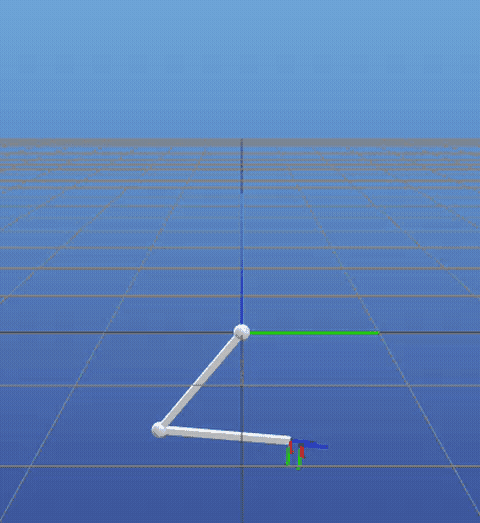

Now we are succesfully able to navigate to the optimal solution. You can see that initially it almost made its way to the local optima, but it hit the boundary, got sidetracked and pushed onto the right direction.

Typically, these sort of constraints are implemented as inequalities with a quadratic programming framework (https://en.wikipedia.org/wiki/Quadratic_programming). You can read more about it here (https://hua-zhou.github.io/teaching/biostatm280-2019spring/slides/26-qp/qp.html).

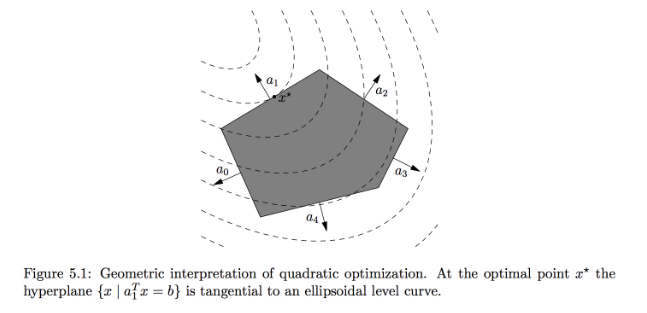

You can from this image how we have multiple constraints / inequalities that combine together to form the polygon in this image, and that we have essentially traced the polygon boundary to find the point that has a normal aligned with the gradient of the loss function.

In our method, we have essentially created a square polygon to bound the optimization, but there are no gaurantees that it might not overshoot into the undesirable boundary.

### Conclusion

Hope this was helpful :D Feel free to try out the code examples in this repo which are alot more verbose